In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

cpu


### Data Preparation

Let's first import all the datasets associated to the simulated curves. These correspond to random parameter initializations for Helena's BlaM model of growth. 

The structure of the dataset corresponds to 10,000 unique parameter combinations, each of which consists of three varibales which evolve over time: the species population $n$ in the first position, $b$ the Beta-lactamase enzyme concentration, and $a$ is the antibiotic concentration. We are only interested in embedding the growth dynamics, $n$ in the system. 

We have for each of these sets of parameters and three variables, we have three conditions corresponding to pure growth without any antibiotic, growth with antibiotic, and growth with antibiotic and Bla inhibitor. 

Let's now plot some of the dataset just to confirm what we are looking at. 

## VAE Compression

Next we'll treat VAE compression of these data using a simple convolutional encoder/decoder structure. We'll use a simple CNN encoder/decoder structure for generating our embeddings where we first apply convolutional operators to generate features and then linear layers to embed into the desired latent space. 

In [2]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    running_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        reconstruction, mean, logvar = model(data)
        recon_loss = criterion(reconstruction, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + alpha * kl_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)

            running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

We'll now break up the training and testing sets apart and load them into dataloader. While we're at it we'll also go ahead and define a hyperparameter dictionary to collect all hyperparameters of interest in a single location.

In [2]:
import pandas as pd

In [3]:

all_gpd_data = pd.read_csv("SparcSSD_GPD_per_hr_data_9_25_2023.csv")

#get patients with at least 1 hour > 0.8 GPD_burden between 6 and 72 hrs

patients_meeting_criteria = []
unique_patients = all_gpd_data["pat_ID"].unique()

min_time=1
max_time=120
#min_time = 1
#max_time = 120
burden_threshold = 0.25

for pat in unique_patients:
    pat_data = all_gpd_data[all_gpd_data["pat_ID"]==pat]
    pat_data2 = pat_data[(pat_data["hour"] >= min_time) & (pat_data["hour"] <=max_time)]
    hours_with_min_burden = sum(pat_data2["GPD_vec_ct_div_360"] >= burden_threshold)
    if hours_with_min_burden >= 1:
        patients_meeting_criteria.append(pat)
        
patients_meeting_criteria = pd.Series(patients_meeting_criteria)

#min_time = 1
#max_time= 84

#data of patients meeting criteria
cohort_gpd_data = all_gpd_data[all_gpd_data["pat_ID"].isin(patients_meeting_criteria)]
cohort_gpd_data = cohort_gpd_data[(cohort_gpd_data["hour"] >= min_time) & (cohort_gpd_data["hour"] <= max_time)]

cohort_gpd_data = cohort_gpd_data[cohort_gpd_data["GPD_vec_ct_div_360"] >= 0.25]

pivotted_BCI = cohort_gpd_data.pivot(columns=["hour"], index='pat_ID', values="BCI").fillna(value=-1)
pivotted_BSAR = cohort_gpd_data.pivot(columns=["hour"], index='pat_ID', values="BSAR").fillna(value=-1)

FileNotFoundError: [Errno 2] No such file or directory: 'SparcSSD_GPD_per_hr_data_9_25_2023.csv'

In [5]:
pivotted_BCI.head()

hour,4,5,6,7,8,9,10,11,12,13,...,111,112,113,114,115,116,117,118,119,120
pat_ID,,,,,,,,,,,,,,,,,,,,,
ICARE_0004,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ICARE_0009,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ICARE_0013,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ICARE_0018,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ICARE_0025,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
# Define the hyperparameters
batch_size = 32
latent_dim = 2
alpha =  1e-6
lr= 1e-3
min_lr = 5e-6
epochs = 500
gamma = 0.99
weight_decay= 1e-4
seq_length = pivotted_BCI.shape[1]

In [15]:
#data = np.swapaxes(np.array([pivotted_BCI.values, pivotted_BSAR.values]), 0, 1)

# Split the data into train and test sets
train_data, test_data, train_indices, test_indices = train_test_split(pivotted_BCI.values, range(pivotted_BCI.shape[0]), test_size=0.5, random_state=42)


#prepare data for training.
scaler = MinMaxScaler()
train_data=scaler.fit_transform(train_data)
test_data=scaler.transform(test_data)


# Convert data into tensor
train_data = torch.tensor(train_data).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
train_data = train_data.unsqueeze(1)

test_data = torch.tensor(test_data).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
test_data = test_data.unsqueeze(1)

train_data = train_data.clone().detach().float()
test_data = test_data.clone().detach().float()

print(train_data.shape)

# Prepare DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

torch.Size([150, 1, 117])


Now we'll define the actual training loop and execute it: 

In [16]:
# Model creation, loss function, and optimizer
model = VAE(latent_dim=latent_dim)
model = model.to(device)
print(f'The model has {count_parameters(model):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

# Training loop
train_loss_values = []
test_loss_values = []

# Initialize early stopping parameters
best_test_loss = np.inf  # Best test loss so far
epochs_no_improve = 0  # Counter for epochs since the test loss last improved
patience = 100 # Patience for early stopping

model

The model has 78,853 parameters


VAE(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): LeakyReLU(negative_slope=0.01)
    )
    (fc_mean): Linear(in_features=1872, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=1872, out_features=2, bias=True)
  )
  (decoder): CNNDecoder(
    (fc): Linear(in_features=2, out_features=1872, bias=True)
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.01)
      (1): ConvTranspose1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): LeakyReLU(negative_slope=0.01)
      (3): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), 

In [17]:
from tqdm.notebook import trange

# implements a warmup schedule to start from a small learn rate. 
warmup_epochs = 8
def warmup_scheduler(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 1.0

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_scheduler)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, alpha)
    test_loss = test(model, test_loader, criterion)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    # Clamp minimum learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch < 10 else 100
    if (epoch + 1) % interval == 0:
        print('Epoch: {} Train: {:.7f}, Test: {:.7f}, Lr:{:.8f}'.format(epoch + 1, train_loss_values[epoch], test_loss_values[epoch], param_group['lr']))
    
    # Update learning rate
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0  # Reset the counter
    else:
        epochs_no_improve += 1  # Increment the counter

    if epochs_no_improve == patience:
        print('Early stopping!')
        break  # Exit the loop

# After training, get the latent variables
train_latent_vars = get_latent_variables(model, train_loader)
test_latent_vars = get_latent_variables(model, test_loader)    

Epoch: 2 Train: 0.1371777, Test: 0.1365130, Lr:0.00025000
Epoch: 4 Train: 0.1313755, Test: 0.1314215, Lr:0.00050000
Epoch: 6 Train: 0.1261187, Test: 0.1284214, Lr:0.00075000
Epoch: 8 Train: 0.1125315, Test: 0.1036410, Lr:0.00100000
Epoch: 10 Train: 0.0933687, Test: 0.0977987, Lr:0.00099000
Epoch: 100 Train: 0.0402598, Test: 0.0779505, Lr:0.00040068
Early stopping!


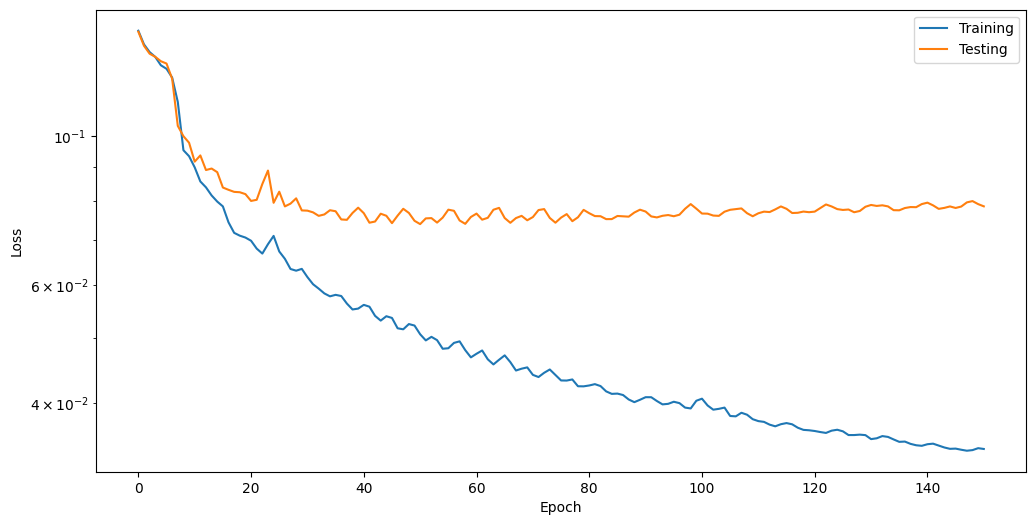

In [18]:
# Plotting the loss values
plt.figure(figsize=(12, 6))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
train_latent_vars.shape[0]

150

In [20]:
test_latent_vars.shape[0]

150

In [21]:
test_pts = pivotted_BCI.index.values[test_indices]
train_pts = pivotted_BCI.index.values[train_indices]

In [22]:
physionet_table = pd.read_csv("train_test_val_physionet_table.csv")
outcome_dict = dict(zip(physionet_table["Patient"], physionet_table["Outcome"]))

In [23]:
test_outcomes = [outcome_dict[test_pt] for test_pt in test_pts]
train_outcomes = [outcome_dict[train_pt] for train_pt in train_pts]

In [24]:
test_vars = pd.DataFrame(test_latent_vars.numpy())
test_vars["label"] = test_outcomes


train_vars = pd.DataFrame(train_latent_vars.numpy())
train_vars["label"] = train_outcomes

In [25]:
import seaborn as sns

c:\Users\vkarukonda\AppData\Local\miniconda3\envs\physionet\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vkarukonda\AppData\Local\miniconda3\envs\physionet\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vkarukonda\AppData\Local\miniconda3\envs\physionet\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vkarukonda\AppData\Local\miniconda3\envs\physionet\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categ

<Axes: xlabel='0', ylabel='1'>

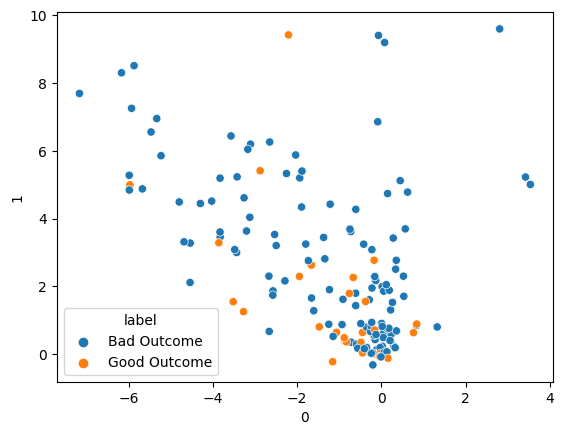

In [26]:
sns.scatterplot(x = 0, y = 1, hue = "label", data = test_vars)